In [1]:
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
from transformers import SamProcessor, SamModel
import torch
import numpy as np
import cv2

In [2]:
yolo_model = YOLO("./camus/train/weights/best.pt")

# facebook/sam-vit-large
# facebook/sam-vit-huge
# facebook/sam-vit-base

SAM_MODEL = "facebook/sam-vit-base"

processor = SamProcessor.from_pretrained("/home/aistudent/camus/medsam")
sam_model = SamModel.from_pretrained("/home/aistudent/camus/medsam")
#sam_model.load_state_dict(torch.load('medsam_vit_b.pth'))
device = "cuda" if torch.cuda.is_available() else "cpu"
sam_model = sam_model.to(device)

In [3]:
results = yolo_model("out/val/images/patient0451_2CH_ED.jpeg")
im_bgr = results[0].plot()
im_rgb = Image.fromarray(im_bgr[..., ::-1])
#plt.imshow(im_rgb)


image 1/1 /home/aistudent/camus/out/val/images/patient0451_2CH_ED.jpeg: 544x640 1 zero, 1 one, 1 two, 98.5ms
Speed: 3.7ms preprocess, 98.5ms inference, 241.3ms postprocess per image at shape (1, 3, 544, 640)


In [4]:
bbox_idx = 2
bbox = results[0].boxes[bbox_idx].xyxy.cpu().numpy()
bbox = bbox.tolist()[0]

In [5]:
image_orig = Image.open(f"out_SAM/val/images/patient0451_2CH_ED_{bbox_idx+1}.jpeg")
image = image_orig.convert("RGB")
mask = Image.open(f"out_SAM/val/masks/patient0451_2CH_ED_{bbox_idx+1}.png")

inputs = processor(image, input_boxes=[[bbox]], return_tensors="pt").to(device)
with torch.no_grad():
    outputs = sam_model(**inputs, multimask_output=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..256].


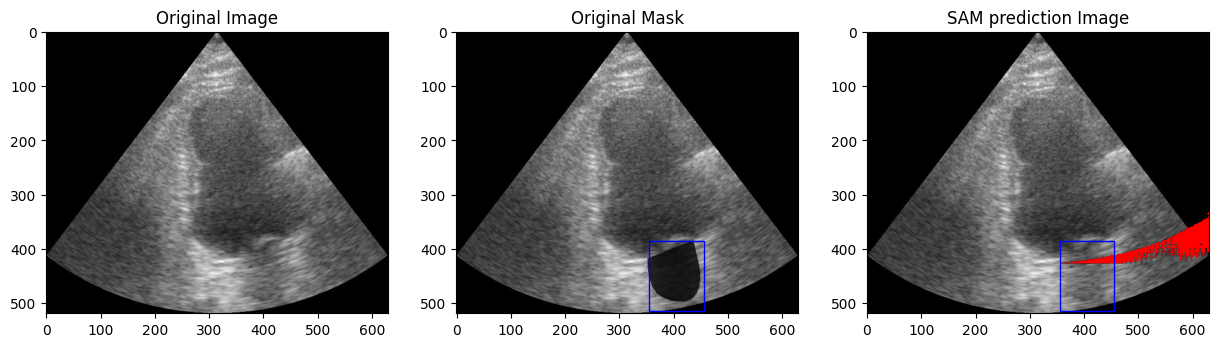

In [6]:
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg > 0.5).astype(np.uint8)
medsam_seg = cv2.resize(
    medsam_seg,
    (np.array(image).shape[1], np.array(image).shape[0]),
    interpolation=cv2.INTER_NEAREST,
)


red_mask = np.stack(
    [
        medsam_seg * 255,
        np.zeros_like(medsam_seg),
        np.zeros_like(medsam_seg),
        (medsam_seg > 0) * 256,  # Alpha channel, 0 means transparent, 255 means opaque
    ],
    axis=-1,
)

red_mask_orig = np.stack(
    [
        np.array(mask) * 255,
        np.zeros_like(np.array(mask)),
        np.zeros_like(np.array(mask)),
        (np.array(mask) > 0) * 200,  # Alpha channel
    ],
    axis=-1,
)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns subplot

axs[0].imshow(image)
axs[0].set_title("Original Image")

axs[1].imshow(image)
axs[1].imshow(red_mask_orig)
axs[1].set_title("Original Mask")

axs[2].imshow(image)
axs[2].imshow(red_mask)
axs[2].set_title("SAM prediction Image")

x1, y1, x2, y2 = bbox

axs[1].add_patch(
    matplotlib.patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1, edgecolor="b", facecolor="none"
    )
)
axs[2].add_patch(
    matplotlib.patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1, edgecolor="b", facecolor="none"
    )
)

plt.show()

In [7]:
from monai.metrics import compute_generalized_dice


medsam_seg = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg > 0.5).astype(np.uint8)
medsam_seg = cv2.resize(medsam_seg, (np.array(image).shape[1], np.array(image).shape[0]), interpolation = cv2.INTER_NEAREST) # Hardcoded mask size, need to change
compute_generalized_dice(torch.tensor(medsam_seg).unsqueeze(0), torch.tensor(np.array(mask)).unsqueeze(0))

tensor([0.0295])